In [1]:
# import data analysis and visualization libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import nltk and related packages
import nltk
import re
import string
from nltk.corpus import stopwords

# import sklearn libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [8]:
# Reading the dataset

df = pd.read_csv('BX-Books.csv' , sep=';', error_bad_lines=False, encoding="latin-1" )
df.columns = ['Book_ID', 'title', 'Book_Author', 'yearOfPublication', 'publisher', 
              'imageUrlS', 'imageUrlM', 'imageUrlL']

In [9]:
df = df.head(50000)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Book_ID            50000 non-null  object
 1   title              50000 non-null  object
 2   Book_Author        50000 non-null  object
 3   yearOfPublication  50000 non-null  object
 4   publisher          50000 non-null  object
 5   imageUrlS          50000 non-null  object
 6   imageUrlM          50000 non-null  object
 7   imageUrlL          50000 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB


In [10]:
# dropping irrelevant columns

df.drop(['Book_ID','yearOfPublication','publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL'], axis =1, inplace=True)
df.head(5)

,title,Book_Author
0,Classical Mythology,Mark P. O. Morford
1,Clara Callan,Richard Bruce Wright
2,Decision in Normandy,Carlo D'Este
3,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,The Mummies of Urumchi,E. J. W. Barber


In [11]:
# Text Preprocessing Functions

def preprocess_text(text):
    
    text = re.sub(r"http\S+", "", text) # removes links
    text = re.sub("[^A-Za-z]+", " ", text) # removes numbers and special chars
    
    tokens = nltk.word_tokenize(text)  #  creates tokens
    tokens = [w for w in tokens if not w.lower() in stopwords.words("english")] # checks for stopwords and removes it.
    text = " ".join(tokens)  # joins all tokens again
    text = text.lower().strip()  # cleaned text
    
    return text

In [12]:
df['cleaned'] = df['title'].apply(lambda x: preprocess_text(x))
df.head(5)

,title,Book_Author,cleaned
0,Classical Mythology,Mark P. O. Morford,classical mythology
1,Clara Callan,Richard Bruce Wright,clara callan
2,Decision in Normandy,Carlo D'Este,decision normandy
3,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,flu story great influenza pandemic search viru...
4,The Mummies of Urumchi,E. J. W. Barber,mummies urumchi


In [13]:
# TF-IDF vectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
X = vectorizer.fit_transform(df['cleaned'])

In [14]:
# KMeans with 5 clusters

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_

In [15]:
# Finding the inertia of the model 

kmeans.inertia_

46449.911610101546

In [16]:
# Initialize PCA with 2 components
# PCA is done only to acheive the 2D visualization for clusters

pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(X.toarray())
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [17]:
# creating new columns for clusters and new dimensions in data frame

df['cluster'] = clusters
df['X0'] = x0
df['X1'] = x1

In [18]:
# Getting top Keywords for each cluster

def get_top_keywords(n_terms):

    df = pd.DataFrame(X.todense()).groupby(clusters).mean()
    terms = vectorizer.get_feature_names() 
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # find the n terms having the highest tf idf score
            
get_top_keywords(10)


Cluster 0
mystery,world,guide,classics,harlequin,paperback,stories,life,love,book

Cluster 1
boss,love,time,novel,president,fortune,mother,memoir,father,daughter

Cluster 2
dream,book,christmas,dark,world,novel,midsummer,harlequin,one,night

Cluster 3
life,last,vintage,stephanie,plum,girl,love,book,suspense,novel

Cluster 4
du,en,les,las,los,del,le,el,la,de


In [19]:
# mapping clusters through get_top_keywords

cluster_map = {0: "thriller", 1: "biography", 2: "novels", 3: "romance", 4: "spanish"} 
df['cluster'] = df['cluster'].map(cluster_map)

In [20]:
df.head(5)

,title,Book_Author,cleaned,cluster,X0,X1
0,Classical Mythology,Mark P. O. Morford,classical mythology,thriller,-0.011663,0.000556
1,Clara Callan,Richard Bruce Wright,clara callan,thriller,-0.011255,0.000678
2,Decision in Normandy,Carlo D'Este,decision normandy,thriller,-0.011494,0.000585
3,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,flu story great influenza pandemic search viru...,thriller,-0.018432,-0.011942
4,The Mummies of Urumchi,E. J. W. Barber,mummies urumchi,thriller,-0.011255,0.000678


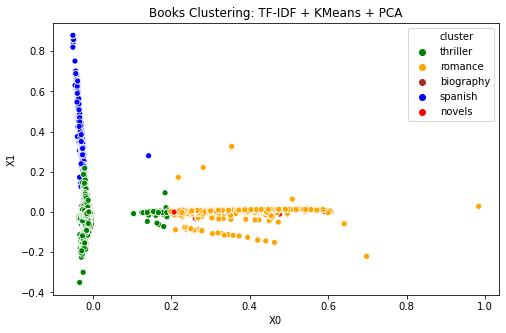

In [21]:
# Plotting the Clusters

plt.figure(figsize=(8, 5))
plt.title("Books Clustering: TF-IDF + KMeans + PCA")
plt.xlabel("X0")
plt.ylabel("X1")
sns.scatterplot(data=df, x='X0', y='X1', hue='cluster', palette=['green','orange','brown','blue','red'], legend='full')
plt.legend()
plt.show()

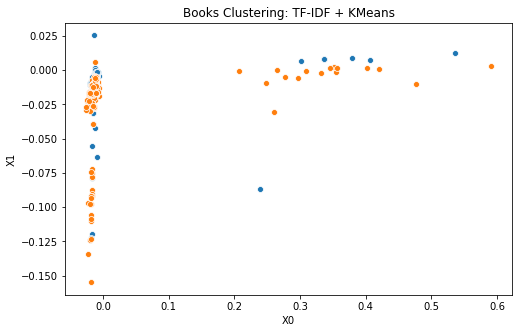

In [22]:
# checking Clusters that are not highly visible

plt.figure(figsize=(8, 5))
plt.title("Books Clustering: TF-IDF + KMeans")
sns.scatterplot(data=df[df['cluster'] =='biography'], x='X0', y='X1', palette ='Blues')
sns.scatterplot(data=df[df['cluster'] =='novels'], x='X0', y='X1', palette = 'Oranges')
plt.show()

In [28]:
# Predicting Labels of a new Title

new_title = "Daughter of Palestine"
Y = vectorizer.transform([new_title])
predicted = kmeans.predict(Y) 
print(predicted)

[1]


In [29]:
genre = {0: "thriller", 1: "biography", 2: "novels", 3: "romance", 4: "spanish"}

for key,value in genre.items():
    if key == predicted:
         print(new_title, "is a", value)

Daughter of Palestine is a biography
